# 2.0 DATA UNDERSTANDING STAGE

### 2.1 Install required libraries 

# Intall required libraries
!pip install numpy
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install imblearn
!pip install boruta


### 2.2 Import Required libraries

In [119]:
import numpy as np
import pandas as pd
import requests
import zipfile
from io import BytesIO
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2_contingency
from sklearn.linear_model import Ridge
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from boruta import BorutaPy
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from itertools import product





## 2.3 Data scraping and extraction
### Create URL of the zip file

In [2]:
secom_zip_url = "https://archive.ics.uci.edu/static/public/179/secom.zip"

### download the zipfile using request library

In [3]:
secom_zip_file = requests.get(secom_zip_url)

#### Identify list of the files on the zipfile

In [4]:
secom_files =  zipfile.ZipFile(BytesIO(secom_zip_file.content), 'r')

secom_files_names =  (zipfile.ZipFile(BytesIO(secom_zip_file.content))).namelist()
print(secom_files_names)

['secom.data', 'secom.names', 'secom_labels.data']


### create paths for features and label data

In [5]:
f_file = secom_files.open('secom.data')
l_file = secom_files.open('secom_labels.data')

In [6]:
#Create  column names and pandas dataframes for labels data

l_column_names=['classifications', 'date_time'] # create column labels

labels_df = pd.read_csv(l_file, sep=r'\s+', header=None, names= l_column_names)

print(f"Dimensions of Labels data: ", labels_df.shape)

print(labels_df.head())


Dimensions of Labels data:  (1567, 2)
   classifications            date_time
0               -1  19/07/2008 11:55:00
1               -1  19/07/2008 12:32:00
2                1  19/07/2008 13:17:00
3               -1  19/07/2008 14:43:00
4               -1  19/07/2008 15:22:00


#### convert time stamps column to datetime format and Check if the timestamps column is ordinal (from latest to ealatest  time)


In [7]:
labels_df['date_time'] = pd.to_datetime(labels_df['date_time'], format='%d/%m/%Y %H:%M:%S')

is_ascending = labels_df['date_time'].is_monotonic_increasing

if is_ascending:
    print("The timestamps column is in ascending order.")
else:
    print("The timestamps column is not in ascending order.")

The timestamps column is in ascending order.


#### Create column names pandas dataframes features data

In [8]:
f_column_names = [f"feature_{i}" for i in range(1, 592)]

secom_features_df = pd.read_csv(f_file, sep=r'\s+', header=None, names= f_column_names)
print(f"Dimensions of Features' data: ", secom_features_df.shape)

print(secom_features_df.head())

Dimensions of Features' data:  (1567, 591)
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    3030.93    2564.00  2187.7333  1411.1265     1.3602      100.0   
1    3095.78    2465.14  2230.4222  1463.6606     0.8294      100.0   
2    2932.61    2559.94  2186.4111  1698.0172     1.5102      100.0   
3    2988.72    2479.90  2199.0333   909.7926     1.3204      100.0   
4    3032.24    2502.87  2233.3667  1326.5200     1.5334      100.0   

   feature_7  feature_8  feature_9  feature_10  ...  feature_582  feature_583  \
0    97.6133     0.1242     1.5005      0.0162  ...          NaN       0.5005   
1   102.3433     0.1247     1.4966     -0.0005  ...     208.2045       0.5019   
2    95.4878     0.1241     1.4436      0.0041  ...      82.8602       0.4958   
3   104.2367     0.1217     1.4882     -0.0124  ...      73.8432       0.4990   
4   100.3967     0.1235     1.5031     -0.0031  ...          NaN       0.4800   

   feature_584  feature_585  feature_586  f

## 2.4 Data Exploration
### Draw Histogram of Volatilities

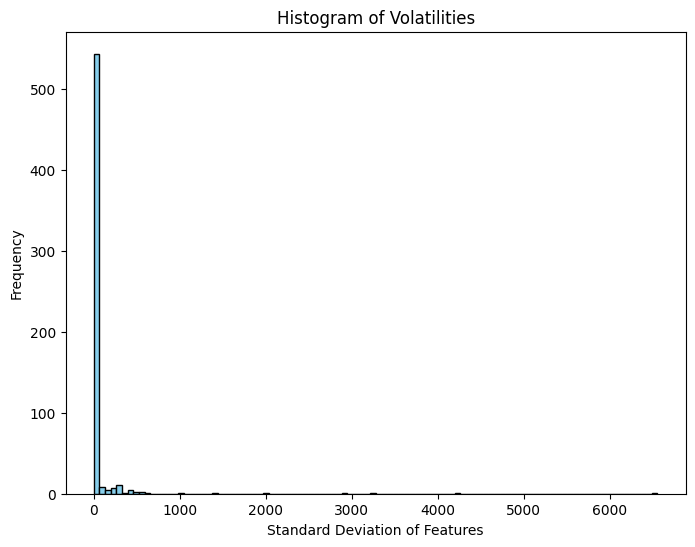

In [9]:
import matplotlib.pyplot as plt
# Calculate volatilities (standard deviations) for each column
volatilities = secom_features_df.std()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(volatilities, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Standard Deviation of Features')
plt.ylabel('Frequency')
plt.title('Histogram of Volatilities')
plt.grid(False)
plt.show()

### Draw a frequency distribution table and a pie chart of the classification variable

Frequency Distribution Table:
   Class  Frequency  Percentage
0     -1       1463   93.363114
1      1        104    6.636886


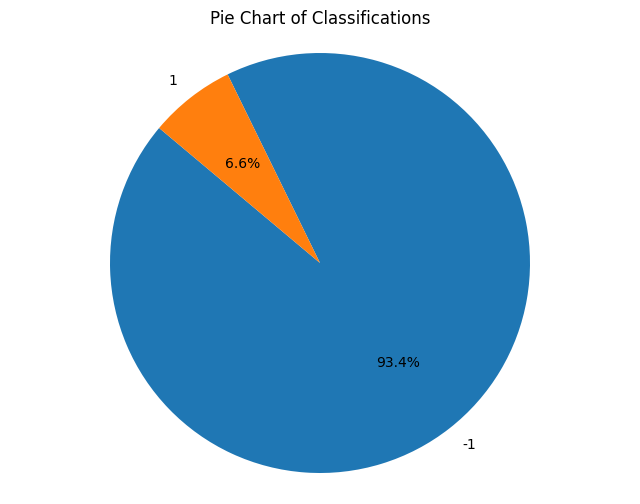

In [10]:
# Calculate frequency distribution
frequency_table = labels_df['classifications'].value_counts().reset_index()
frequency_table.columns = ['Class', 'Frequency']

# Calculate percentage
total_count = frequency_table['Frequency'].sum()
frequency_table['Percentage'] = (frequency_table['Frequency'] / total_count) * 100

# Display frequency distribution table
print("Frequency Distribution Table:")
print(frequency_table)

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(frequency_table['Frequency'], labels=frequency_table['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Classifications')
plt.axis('equal')
plt.show()


### Correlation heatmap

           feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
feature_1   1.000000  -0.145071   0.004775  -0.007655  -0.011047        NaN   
feature_2  -0.145071   1.000000   0.005802  -0.007603  -0.001641        NaN   
feature_3   0.004775   0.005802   1.000000   0.298935   0.095891        NaN   
feature_4  -0.007655  -0.007603   0.298935   1.000000  -0.058483        NaN   
feature_5  -0.011047  -0.001641   0.095891  -0.058483   1.000000        NaN   

           feature_7  feature_8  feature_9  feature_10  ...  feature_582  \
feature_1   0.002281   0.031510  -0.052731    0.009052  ...    -0.028380   
feature_2  -0.025702  -0.012084   0.031321    0.024015  ...     0.083463   
feature_3  -0.136225  -0.273970   0.023609    0.016291  ...    -0.010759   
feature_4  -0.685835   0.138290  -0.103656    0.068998  ...    -0.096619   
feature_5  -0.074368  -0.916410  -0.026035    0.054619  ...     0.088327   

           feature_583  feature_584  feature_585  feature_586  featu

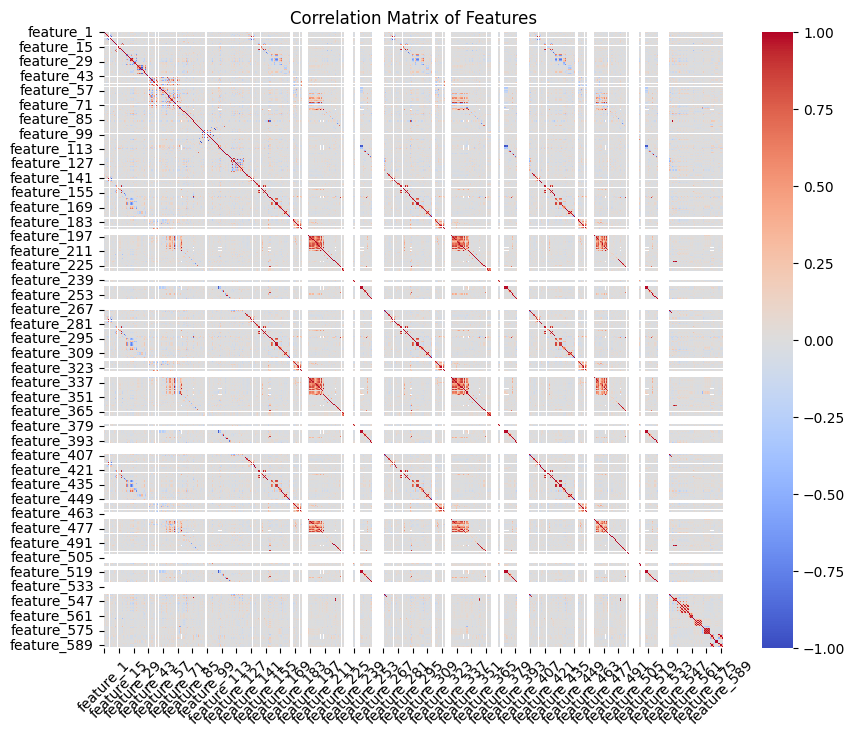

In [11]:
import seaborn as sns
# Compute the correlation matrix
correlation_matrix = secom_features_df.corr()
print(correlation_matrix.head())
# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.show()

###  Check the Count and Percentages of Missing values in the dataframe

Number of columns WITHOUT Missing Values:
52
Number of columns WITH Missing Values:
539
Frequency Table of Percentage of Missing Values in Each Column:
     Bin  Frequency
0  <=55%        514
1   >55%         25


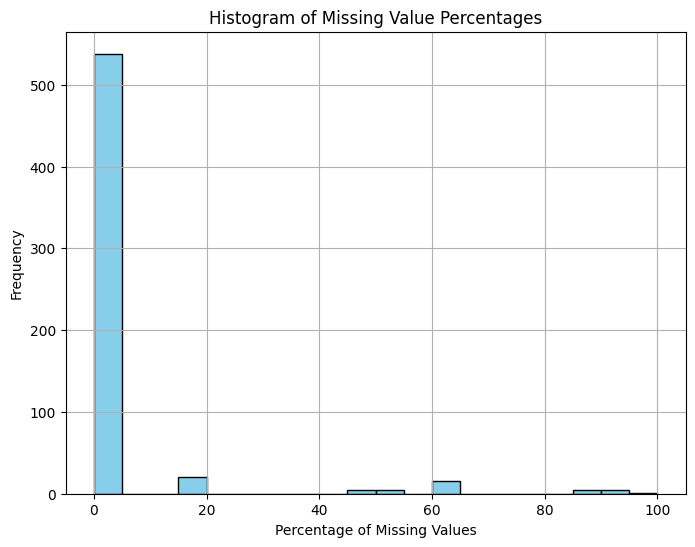

In [12]:

# Calculate percentage of missing values in each column
missing_percentages2 = (secom_features_df.isnull().sum() / len(secom_features_df)) * 100

# Create bins
bins = [0, 55, 100]

# Use pd.cut to categorize percentages into bins
bin_labels = ['<=55%', '>55%']
categories = pd.cut(missing_percentages2, bins, labels=bin_labels)

# Create a DataFrame to store the frequency table
frequency_table2 = categories.value_counts().reset_index()
frequency_table2.columns = ['Bin', 'Frequency']

# Determine the number of columns with and without missing values
print("Number of columns WITHOUT Missing Values:")
print((secom_features_df.isnull().sum() == 0).sum())

print("Number of columns WITH Missing Values:")
print((secom_features_df.isnull().sum()>0).sum())


print("Frequency Table of Percentage of Missing Values in Each Column:")
print(frequency_table2)

# Plot a histogram of the missing value percentages
plt.figure(figsize=(8, 6))
plt.hist(missing_percentages2, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Value Percentages')
plt.grid(True)
plt.show()




In [13]:
# duplicate identification

# Find columns with 100% duplicate values
columns_with_100_percent_duplicates = secom_features_df.columns[secom_features_df.nunique() == 1]

print("Columns with 100% duplicate values:")
print(len(columns_with_100_percent_duplicates))

print("Pecentage of Columns with 100% duplicate values:")

print(len(columns_with_100_percent_duplicates)/len(secom_features_df.columns)*100, "%")


Columns with 100% duplicate values:
116
Pecentage of Columns with 100% duplicate values:
19.627749576988155 %


# 3.0 DATA PREPARATION

### 3.1 Merge the Features and Labels data frames

In [14]:
secom_merged_df = pd.merge(labels_df, secom_features_df, left_index=True, right_index=True)

print(f"Dimensions of merged data: ", secom_merged_df.shape)

print(secom_merged_df.head())

Dimensions of merged data:  (1567, 593)
   classifications           date_time  feature_1  feature_2  feature_3  \
0               -1 2008-07-19 11:55:00    3030.93    2564.00  2187.7333   
1               -1 2008-07-19 12:32:00    3095.78    2465.14  2230.4222   
2                1 2008-07-19 13:17:00    2932.61    2559.94  2186.4111   
3               -1 2008-07-19 14:43:00    2988.72    2479.90  2199.0333   
4               -1 2008-07-19 15:22:00    3032.24    2502.87  2233.3667   

   feature_4  feature_5  feature_6  feature_7  feature_8  ...  feature_582  \
0  1411.1265     1.3602      100.0    97.6133     0.1242  ...          NaN   
1  1463.6606     0.8294      100.0   102.3433     0.1247  ...     208.2045   
2  1698.0172     1.5102      100.0    95.4878     0.1241  ...      82.8602   
3   909.7926     1.3204      100.0   104.2367     0.1217  ...      73.8432   
4  1326.5200     1.5334      100.0   100.3967     0.1235  ...          NaN   

   feature_583  feature_584  feature_585

### 3.2 Split data into Training and Test data

In [15]:
# Seperate features series and target variable series
X = secom_merged_df.drop(["classifications", "date_time"], axis=1).values
y = secom_merged_df["classifications"].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### 3.3 Descriptives of trian and test data for both features and target variable

##### check the shape of train and test datasets

In [16]:
print("Shape of features training data: ")
print(np.shape(X_train))
print("Shape of target training data: ")
print(np.shape(y_train))
print("Shape of features test data: ")
print(np.shape(X_test))
print("Shape of taget test data: ")
print(np.shape(y_test))

Shape of features training data: 
(1175, 591)
Shape of target training data: 
(1175,)
Shape of features test data: 
(392, 591)
Shape of taget test data: 
(392,)


#### Check the composition of the target variable in the Training and test data

In [17]:
#Create a function to create frequency table

def draw_frequency(data):
    # Calculate frequency distribution
    unique_values, counts = np.unique(data, return_counts=True)

    # Calculate total count
    total_count = len(data)

    # Calculate percentage distribution
    percentage_counts = counts / total_count * 100

    # Merge frequency and percentage distributions into a single NumPy array
    distribution = np.stack((unique_values, counts, percentage_counts), axis=-1)
    
    # Convert them to pandas DataFrame
    distribution_df = pd.DataFrame(distribution, columns=['Class', 'Frequency', 'Percentage'])

    return distribution_df

# Draw the distribution of target variable in training and test data set
freuency_y_trn = draw_frequency(y_train)
frequency_y_tst= draw_frequency(y_test)
# Print the result
print("Distribution of target values in train data:")
print(freuency_y_trn)

print("Distribution of target values in test data:")
print(frequency_y_tst)



Distribution of target values in train data:
   Class  Frequency  Percentage
0   -1.0     1097.0   93.361702
1    1.0       78.0    6.638298
Distribution of target values in test data:
   Class  Frequency  Percentage
0   -1.0      366.0   93.367347
1    1.0       26.0    6.632653


### Variance of columns

Number of columns with zero variance: 116
Proportion of Columns with zero variance:
19.627749576988155 %


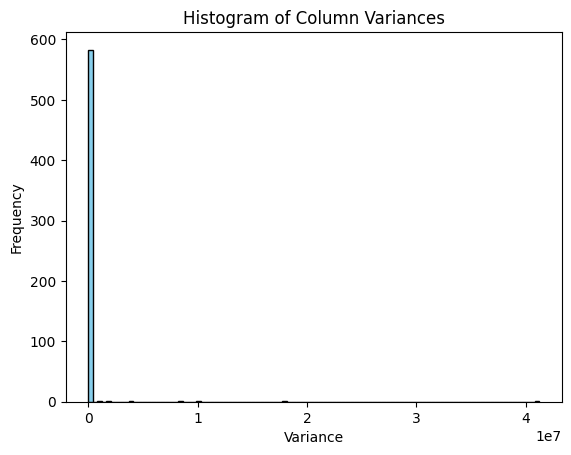

In [18]:
# Convert X_train data to Pandas df
X_train_df = pd.DataFrame(X_train, columns=f_column_names)

# Calculate the variance of each column
column_variances = X_train_df.var()

# Subset the columns with zero variance
zero_variance_columns = column_variances[column_variances == 0].index.tolist()

# Print the columns with zero variance
print("Number of columns with zero variance:", len(zero_variance_columns))

print("Proportion of Columns with zero variance:")

print(len(zero_variance_columns)/len(X_train_df.columns)*100, "%")

#plot histogam of variance

plt.hist(column_variances, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Column Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Convert X_test data to Pandas df

X_test_df = pd.DataFrame(X_test, columns=f_column_names)

###  Check the Count and Percentages of Missing values in each feature

The total number of features WITHOUT Missing Values:
128
The total number of features WITH Missing Values:
463
The total number of features with NAs WITHIN the threshold of 80% NAs:
454
The total number of features with NAs ABOVE the threshold of 80% NAs:
9


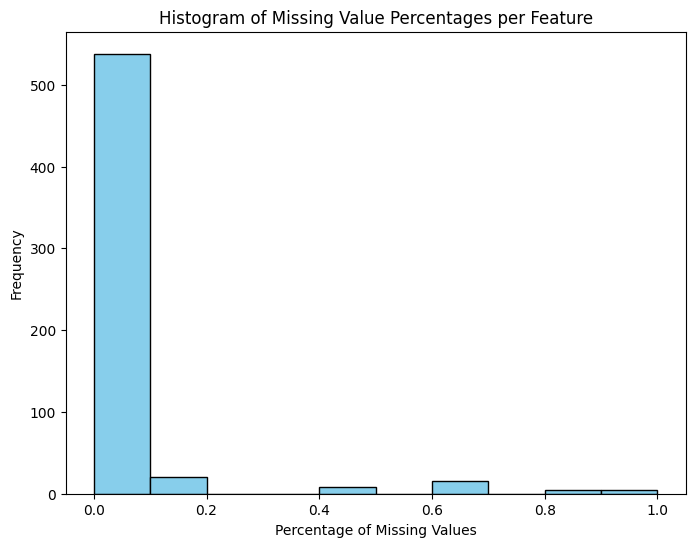

In [20]:
# Calculate percentage of missing values in each feature 
missing_df= X_train_df.isnull().mean()

# Determine the number of features with and without missing values
print("The total number of features WITHOUT Missing Values:")
print((missing_df == 0).sum())

print("The total number of features WITH Missing Values:")
print((missing_df > 0).sum())

# Determine the number of features WITHIN the threshold of 80% NAs

print("The total number of features with NAs WITHIN the threshold of 80% NAs:")
print(((missing_df > 0) & (missing_df <=0.80)).sum())

# Determine the number of features ABOVE the threshold of 80% NAs

print("The total number of features with NAs ABOVE the threshold of 80% NAs:")
print((missing_df > 0.80).sum())


# Plot a histogram of the missing value percentages
plt.figure(figsize=(8, 6))
plt.hist(missing_df, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Value Percentages per Feature')
plt.grid(False)

### Correlation heatmap of X-train data

           feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
feature_1   1.000000  -0.126566   0.000575   0.013373  -0.006222        NaN   
feature_2  -0.126566   1.000000  -0.002103   0.005802  -0.004174        NaN   
feature_3   0.000575  -0.002103   1.000000   0.318834   0.025843        NaN   
feature_4   0.013373   0.005802   0.318834   1.000000  -0.019419        NaN   
feature_5  -0.006222  -0.004174   0.025843  -0.019419   1.000000        NaN   

           feature_7  feature_8  feature_9  feature_10  ...  feature_582  \
feature_1  -0.024898   0.044185  -0.020168    0.018319  ...    -0.020948   
feature_2  -0.031952   0.004616   0.036839    0.014511  ...     0.074886   
feature_3  -0.146916  -0.422301   0.030255   -0.006386  ...    -0.014590   
feature_4  -0.686292   0.179327  -0.095718    0.068795  ...    -0.074088   
feature_5  -0.102886   0.052054   0.000949    0.005682  ...     0.000050   

           feature_583  feature_584  feature_585  feature_586  featu

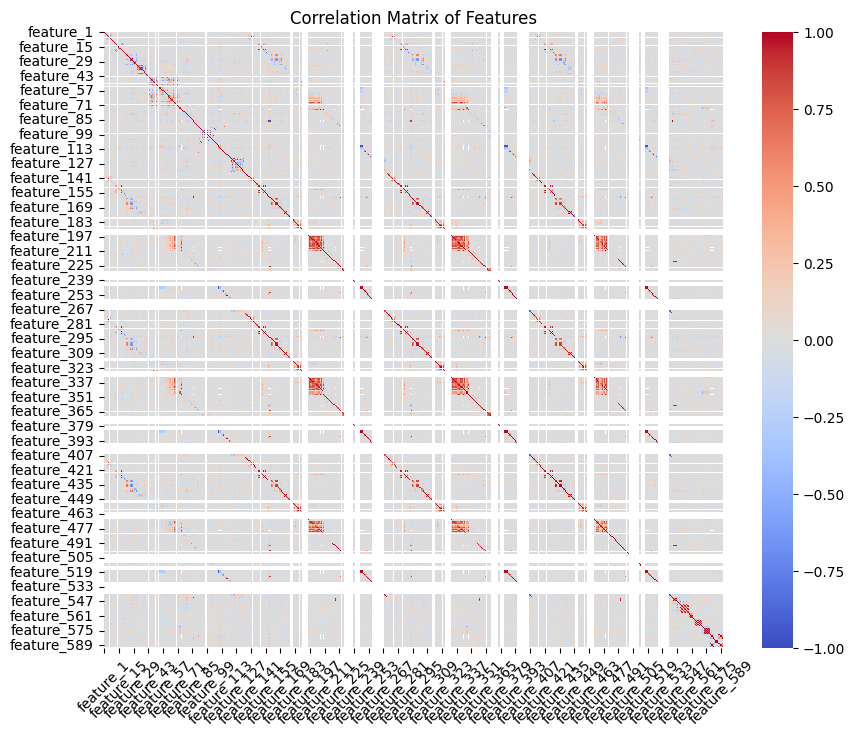

In [21]:
import seaborn as sns
# Compute the correlation matrix
correlation_matrix_Xtrn = X_train_df.corr()
print(correlation_matrix_Xtrn.head())
# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_Xtrn, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.show()

### Create a function to determine highly correlated pair of features

In [22]:
# Create a function to determine highly correlated pair of features above threshold of 0.95
# Determine which features to drop according to Munirathinam & Ramadoss (2016)
# Among each pair, Drop the feature with the highest average correlation with all features
def find_highly_correlated_pairs(df, correlation_threshold=0.95):
    # Step 1: Calculate the correlation matrix
    correlation_matrix = df.corr()
    
    # Step 2: Find pairs of predictors with correlation >= threshold
    high_correlation_pairs = []
    columns = correlation_matrix.columns
    
    # Loop over the upper triangle of the correlation matrix (excluding diagonal)
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                high_correlation_pairs.append((columns[i], columns[j]))

    # Step 3: Create a DataFrame to store the pairs and their correlations
    high_corr_df = pd.DataFrame(high_correlation_pairs, columns=['Predictor_A', 'Predictor_B'])
    high_corr_df['Correlation'] = [
        correlation_matrix.loc[pair[0], pair[1]] for pair in high_correlation_pairs
    ]
    
    # Step 4: Calculate average correlation with other predictors for each element of each pair
    avg_correlation = {}
    
    for col in columns:
        # Calculate the average correlation of a predictor with all others excluding itself
        avg_correlation[col] = correlation_matrix[col].drop(col).abs().mean()
    
    # Add the average correlation to the DataFrame
    high_corr_df['Avg_Corr_A'] = high_corr_df['Predictor_A'].apply(lambda x: avg_correlation[x])
    high_corr_df['Avg_Corr_B'] = high_corr_df['Predictor_B'].apply(lambda x: avg_correlation[x])

    # Step 5: Determine which element has the higher average correlation with other predictors
    # You need to compare the values for each row and assign the predictor with the higher correlation
    high_corr_df['highest_to_delete'] = high_corr_df.apply(
        lambda row: row['Predictor_A'] if row['Avg_Corr_A'] > row['Avg_Corr_B'] else row['Predictor_B'], axis=1
    )

    return high_corr_df

### Determine the list of highly correlated pair of features and
### Create the the list of highly correlated of features to DROP

In [23]:
# Create a dataframe to determine the highly correlated pair of features
correlation_result = find_highly_correlated_pairs(X_train_df, correlation_threshold=0.95)
print(correlation_result.head())
print(correlation_result.tail())

# Determine the List of unique Features to Drop
features_to_drop =correlation_result['highest_to_delete']
features_to_drop_unq =correlation_result['highest_to_delete'].unique()
# Print the first 5 features and the number of features to drop
print(features_to_drop_unq[1:6])

print("Number of highly correlated Features to drop:", len(features_to_drop))

print("Unique number of highly correlated Features to drop:", len(features_to_drop_unq))



  Predictor_A  Predictor_B  Correlation  Avg_Corr_A  Avg_Corr_B  \
0   feature_5  feature_141     0.999963    0.029937    0.029817   
1   feature_5  feature_276     0.999964    0.029937    0.029719   
2  feature_17  feature_149     0.978889    0.044948    0.043396   
3  feature_17  feature_153     0.984235    0.044948    0.044442   
4  feature_17  feature_284     0.979643    0.044948    0.043636   

  highest_to_delete  
0         feature_5  
1         feature_5  
2        feature_17  
3        feature_17  
4        feature_17  
     Predictor_A  Predictor_B  Correlation  Avg_Corr_A  Avg_Corr_B  \
335  feature_582  feature_590     1.000000    0.053581    0.042554   
336  feature_584  feature_585     0.996055    0.029074    0.029277   
337  feature_584  feature_586     0.999916    0.029074    0.029103   
338  feature_585  feature_586     0.996450    0.029277    0.029103   
339  feature_588  feature_589     0.971941    0.037520    0.036102   

    highest_to_delete  
335       feature_58

### 3.4 Dimensionality Reduction

### Removing low variance columns

In [24]:
# Function to get low-variance columns
def low_variance_columns(df, variance_threshold=0.95):

    # Compute variance for each column
    column_variance = df.var()
    
    # Select columns with variance below the threshold
    low_variance_cols = column_variance[column_variance < variance_threshold].index
    
    # Return a DataFrame containing only the low-variance columns
    return df[low_variance_cols]

zero_var_cols = low_variance_columns(X_train_df)
# Create list of columns to drop
col_to_drop1=zero_var_cols.columns.tolist()
print(zero_var_cols.shape)
print(col_to_drop1)


(1175, 345)
['feature_6', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_14', 'feature_18', 'feature_20', 'feature_21', 'feature_26', 'feature_27', 'feature_30', 'feature_31', 'feature_32', 'feature_38', 'feature_39', 'feature_43', 'feature_45', 'feature_48', 'feature_50', 'feature_53', 'feature_54', 'feature_55', 'feature_57', 'feature_58', 'feature_59', 'feature_62', 'feature_70', 'feature_75', 'feature_76', 'feature_77', 'feature_78', 'feature_79', 'feature_80', 'feature_81', 'feature_82', 'feature_83', 'feature_84', 'feature_85', 'feature_86', 'feature_87', 'feature_88', 'feature_90', 'feature_92', 'feature_93', 'feature_94', 'feature_95', 'feature_96', 'feature_97', 'feature_98', 'feature_99', 'feature_100', 'feature_101', 'feature_102', 'feature_103', 'feature_104', 'feature_105', 'feature_106', 'feature_107', 'feature_108', 'feature_109', 'feature_110', 'feature_113', 'feature_114', 'feature_115', 'feature_117', 'feature_119', 'feature_120', 'featur

### Create new dataframe without low variance columns

In [25]:
# Function to get low-variance columns
def drop_low_var_columns(df, variance_threshold=0.0000000001):

    # Compute variance for each column
    column_variance = df.var()
    
    # Select columns with variance below the threshold
    low_variance_cols = column_variance[column_variance < variance_threshold].index
    
    # Return a DataFrame without low-variance columns
  
    return df.drop(columns=low_variance_cols)

# Create a new dataframe without low variance columns
X_train_df1 = drop_low_var_columns(X_train_df)

# Create a list of columns dropped
columns_dropped1 = list(set(X_train_df.columns) - set(X_train_df1.columns))

# confirm the changes in number of columns

print("Original number of columns: ", X_train_df.shape[1])
print("Number of columns dropped: ", len(columns_dropped1))
print("New number of columns: ", X_train_df1.shape[1])



Original number of columns:  591
Number of columns dropped:  116
New number of columns:  475


### Drop Null Values columns below percentage threshold

In [26]:
# Function to drop missing values below a given treshhold

def drop_na_columns(df, threshold): # threshold in absolute percentage e.g. 90

    # Create missing values df
    na_percent = round(df.isnull().mean() * 100)

       # Create a list of columns with missing values above the threshold
    cols_to_drop = na_percent[na_percent > threshold].index.tolist()
    
    # Print the columns to be dropped for debugging
    print(f"Columns to be dropped (greater than {threshold}% missing values): {cols_to_drop}")
    
    # Print number of columns of original datafame
    print("Original number of columns: ", len(df.columns))
    
    # Print number of columns dropped
    print("Number of columns dropped: ", len(cols_to_drop))
    
    
    # Return a new DataFrame with the specified columns dropped
    df_cleaned = df.drop(columns=cols_to_drop)
    
    return df_cleaned


    

In [27]:
# Drop NAs columns
X_train_df2 = drop_na_columns(X_train_df1, 70)



Columns to be dropped (greater than 70% missing values): ['feature_86', 'feature_158', 'feature_159', 'feature_221', 'feature_293', 'feature_294', 'feature_359', 'feature_493', 'feature_591']
Original number of columns:  475
Number of columns dropped:  9


In [28]:
len(X_train_df2.columns)

466

In [29]:
columns_dropped2= ['feature_86', 'feature_158', 'feature_159', 'feature_221', 'feature_293', 'feature_294', 'feature_359', 'feature_493', 'feature_591']

### 3.5 Treating Outliers
### Outliers Identification based on 3s rule

In [30]:
# Define function
def identify_outliers(df):
   
    # Calculate mean and standard deviation
    mean = df.mean()
    std_dev = df.std()
    
    # Define boundaries for outliers
    upper_bound = mean + 3 * std_dev
    lower_bound = mean - 3 * std_dev
    
    # Create a boolean mask for outliers
    outliers_mask = (df > upper_bound) | (df < lower_bound)
    
    return outliers_mask

### Create a function to identify 3s boundaries

In [31]:
def identify_lower_upper(df):
   
    # Calculate mean and standard deviation
    mean = df.mean()
    std_dev = df.std()
    
    # Define boundaries for outliers
    upper_bound = mean + 3 * std_dev
    lower_bound = mean - 3 * std_dev
    
    
    return lower_bound, upper_bound

### Create a function to fill outliers with upper / lower boundaries

In [32]:
# outlierFill function
def fill_outliers(df):
   
    # Calculate mean and standard deviation
    mean = df.mean()
    std_dev = df.std()
    
    # Define boundaries for outliers
    upper_bound = mean + 3 * std_dev
    lower_bound = mean - 3 * std_dev
    
    # Create a boolean mask for outliers
    df_filled = df.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    return df_filled


### Fill Outliers with 3s boundaries 

In [33]:
X_train_filled = fill_outliers(X_train_df2)
print(X_train_filled)


      feature_1  feature_2  feature_3  feature_4  feature_5  feature_7  \
0       3057.03    2468.41  2184.8778   960.8486     1.0160   102.5333   
1       3012.09    2551.08  2216.7333  1748.0885     1.1127    97.5822   
2       3032.81    2534.74  2239.4223  1997.3782     1.5397    98.3356   
3       2987.72    2550.52  2180.7000  1159.3838     1.0177    98.9367   
4       3001.90    2465.51  2223.0444  1194.5986     1.2016   112.5811   
...         ...        ...        ...        ...        ...        ...   
1170    3185.69    2537.68  2173.2778  1116.2950     0.8525   103.8200   
1171    2988.92    2460.91  2178.0778   941.9524     0.8039   104.0167   
1172    2975.74    2517.35  2162.5556  1041.0369     1.4305   100.4111   
1173    2928.16    2523.21  2210.6111  1184.6481     1.2577   102.9356   
1174    2929.84    2504.50  2183.3111  1588.5090     1.6269   102.8467   

      feature_8  feature_9  feature_10  feature_11  ...  feature_581  \
0        0.1214     1.4549     -0.0125 

In [34]:
# Confirm that outliers have been filled with class boundaries
print("Original dataframe WITH outliers:")
print(X_train_df2["feature_590"].head(4))
print("lower bound, upper bound: ", identify_lower_upper(X_train_df2["feature_590"]))
print("New dataframe WITHOUT outliers:")
print(X_train_filled["feature_590"].head(4))



Original dataframe WITH outliers:
0     62.1248
1     62.3602
2     35.5550
3    474.0812
Name: feature_590, dtype: float64
lower bound, upper bound:  (-182.016242088725, 378.8615799081458)
New dataframe WITHOUT outliers:
0     62.12480
1     62.36020
2     35.55500
3    378.86158
Name: feature_590, dtype: float64


### 3.6 DATA INPUTATION

#### Impute NAs with KNN

In [35]:
# Create a function to input missing values iwth KNN

def fill_nas_knn (df):
    
    # Define the imputer
    imputer = KNNImputer(n_neighbors=3)  # You can adjust the number of neighbors
    
    # Apply the imputer to the DataFrame
    df_imputed = imputer.fit_transform(df)
    return df_imputed

In [36]:
# Fill in NAs with KNN
X_train_imputed_knn= fill_nas_knn(X_train_filled)

#### Input NAs MICE


In [37]:

 # Enable experimental feature
from sklearn.impute import IterativeImputer
# Create a function to inpute NAs with BayesianRidge as the estimator
def impute_na (data):
    # Create an IterativeImputer with BayesianRidge as the estimator
    imputer = IterativeImputer(random_state=42)

    # Fit the imputer to the DataFrame and transform it to fill in missing values
    data_imputed = imputer.fit_transform(data)
    
    # Create a new DataFrame with the imputed values
    return data_imputed

In [38]:
# impute NAs and create imputed data

X_train_imputed_mice = impute_na(X_train_filled)


c:\Users\MajeedAbdul-Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### 3.7 Scaling of Features

Scaling the dataset with function

In [39]:
# Create a function for resampling the dataframe

def scale_dataset(data):

  scaler = StandardScaler()
  data_scaled = scaler.fit_transform(data)


  return data_scaled

In [40]:
# Scale the train dataset

X_train_scaled_knn = scale_dataset(X_train_imputed_knn)
X_train_scaled_mice = scale_dataset(X_train_imputed_mice)
print (X_train_scaled_knn[1:2, :])
print (X_train_scaled_mice[1:2, :])

[[-0.01376139  0.70469202  0.58621346  0.90372592 -0.07963287 -0.57789513
   0.73011783  0.67146222 -0.51562856  1.42044983 -1.44352223 -0.36149642
  -1.57665922 -0.83581682  0.14430441  0.21374863 -0.38749067  1.26890382
   0.26107486 -1.8967441   0.94966853 -1.82897855  0.48646257 -1.43340616
  -0.52868058 -1.4041703   0.71277469  0.92716832 -0.16611523  1.83462036
  -0.40807529 -0.3522895  -0.86373369  0.13479255  0.86371865 -1.12358711
   0.13817481 -0.31377438  0.41869597  0.25428067  0.3331933   1.14889868
  -0.84896938 -0.44035125 -1.12270432 -0.29058959 -0.68952167 -0.62544158
   1.43753439  1.51763928  0.22508944 -0.32772501 -0.58123361 -0.1380561
   1.81059652  0.57594248  0.31184314 -0.6685355  -0.37137218 -1.07331028
  -0.96521994 -0.26364566 -0.05804383 -0.53771406 -0.36782879  0.05385417
  -0.15476637  0.11566079 -0.02918542  0.33511093  0.26939051 -0.70735831
   0.08410212  0.06465119  1.97995671  0.08015154  0.55502735 -0.49151513
   0.09055097  1.88495312  0.61364224 -

### 3.8 Feature selection with Boruta

#### 3.8.1 Select features with Boruta

In [41]:
# Define a function to Select accepted features Only

def boruta_accepted_only(X, y):
    
    #change integers to new Numpy integers formats required by Boruta package
    np.int = np.int32
    np.float = np.float64
    np.bool = np.bool_

    # Define the model
    model1 = RandomForestClassifier(random_state=42)
    # define Boruta feature selection method
    feat_selector = BorutaPy(model1, n_estimators='auto', verbose=2, random_state=1)

    # find all relevant features
    feat_selector.fit(X.values, y)


    # Results from Boruta
    accepted_features = X.columns[feat_selector.support_].tolist()
    tentative_features = X.columns[feat_selector.support_weak_].tolist()
    rejected_features = X.columns[~(feat_selector.support_ | feat_selector.support_weak_)].tolist()

    print("Number of Accepted features:", accepted_features)
    print("Number of Tentative features:", tentative_features)
    print("Number of Rejected features:", rejected_features)

    # Combine accepted and tentative features
    final_selected_features = accepted_features
    final_X_df= X[final_selected_features]
    print("Final selected features:", final_selected_features)

    #Return final dataframe with only selected features
    return final_X_df.values, final_selected_features  #out need include two data sets, final X_train and list of sected columns for later use




In [42]:
# Define a function to Select accepted and tentative features

def boruta_selector2(X, y, n_features):
    
    #change integers to new Numpy integers formats required by Boruta package
    np.int = np.int32
    np.float = np.float64
    np.bool = np.bool_

    # Define the model
    model1 = RandomForestClassifier(random_state=42)
    # define Boruta feature selection method
    feat_selector = BorutaPy(model1, n_estimators='auto', verbose=2, random_state=1)

    # find all relevant features
    feat_selector.fit(X.values, y)

    # Get the ranks of the features
    feature_ranks = feat_selector.ranking_

    # Create a DataFrame for visualization
    feature_ranks_df = pd.DataFrame({
        'Feature': X.columns,
        'Rank': feature_ranks
    })

    # Sort by rank
    feature_ranks_df = feature_ranks_df.sort_values(by='Rank').reset_index(drop=True)


    # Select the top 30 features
    top_n_features = feature_ranks_df['Feature'].iloc[:n_features].tolist()
    # Results from Boruta
    accepted_features = X.columns[feat_selector.support_].tolist()
    tentative_features = X.columns[feat_selector.support_weak_].tolist()
    rejected_features = X.columns[~(feat_selector.support_ | feat_selector.support_weak_)].tolist()

    print("Number of Accepted features:", accepted_features)
    print("Number of Tentative features:", tentative_features)
    print("Number of Rejected features:", rejected_features)

    # Combine accepted and tentative features
    final_selected_features = top_n_features
    final_X_df= X[top_n_features]
    print("Final selected features:", final_selected_features)

    #Return final dataframe with only selected features
    return final_X_df.values, final_selected_features  #out need include two data sets, final X_train and list of sected columns for later use

### Create a function to sort X_train features by Boruta ranking

In [43]:
# Define a function to Select acepted and tentative features

def boruta_sort_by_rank(X, y):
    
    #change integers to new Numpy integers formats required by Boruta package
    np.int = np.int32
    np.float = np.float64
    np.bool = np.bool_

    # Define the model
    model1 = RandomForestClassifier(random_state=42)
    # define Boruta feature selection method
    feat_selector = BorutaPy(model1, n_estimators='auto', verbose=2, random_state=1)

    # find all relevant features
    feat_selector.fit(X.values, y)

    # Get the ranks of the features
    feature_ranks = feat_selector.ranking_

    # Create a DataFrame for visualization
    feature_ranks_df = pd.DataFrame({
        'Feature': X.columns,
        'Rank': feature_ranks
    })

    # Sort by rank
    feature_ranks_df = feature_ranks_df.sort_values(by='Rank').reset_index(drop=True)

    # extract ranked column names to list
    ranked_columns_list = feature_ranks_df['Feature'].tolist()
    
    # Sort original Df based according to ranks
    X_sorted = X.reindex(columns = ranked_columns_list)
    print(X_sorted.head())

    #Return the sorted or reodered dataframe
    return X_sorted.values 


In [44]:
# Change knnn imputed data set to panda datafame
X_train_filtered_knn_df= pd.DataFrame(X_train_scaled_knn, columns=X_train_df2.columns)


# Change MICE imputed data set to panda datafame
X_train_filtered_mice_df= pd.DataFrame(X_train_scaled_mice, columns=X_train_df2.columns)



### Sort Xtrain based on Boruta ranking to determine number of features to select
#### Sort KNN-imputed data by Boruta Rank

In [45]:
X_train_br_knn_ranked = boruta_sort_by_rank(X_train_filtered_knn_df, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	451
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	12
Rejected: 	452
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	12
Rejected: 	452
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	12
Rejected: 	452
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	12
Rejected: 	452
Iteration: 	16 / 100
Confirmed: 	2
Tentat

#### Sort MICE-imputed data by Boruta Rank

In [46]:
X_train_br_mice_ranked = boruta_sort_by_rank(X_train_filtered_mice_df, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	451
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	451
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	451
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	451
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	16 / 100
Confirmed: 	2
Tentat

In [47]:
# Create a function that predicts the possible combination of Boruta ranked features 
 
def assess_boruta_combinations(X_train, y_train, n, m):
    results = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Loop through increasing number of features
    for num_features in range(n, n + m + 1):
        # Select the first num_features columns from X_train
        X_subset = X_train[:, :num_features]
        
        # Initialize a RandomForestRegressor
        model = RandomForestClassifier(random_state=42)
        
        # Perform cross-validation
        scores = cross_val_score(model, X_subset, y_train, cv=kf, scoring='accuracy')
        
        # Calculate average MSE across folds
        avg_score = np.mean(scores)
        
        # Store the results
        results.append([num_features, avg_score])
    
    # Convert results to a pandas DataFrame
    results_df = pd.DataFrame(results, columns=['number_of_features', 'average_accuracy_score'])
    
    return results_df


#### sort Boruta feature combinations based on rank

In [48]:
# Check the score of upto top 30 most ranked feature combinations (KNN imputed)
top_30_knn_ranked = assess_boruta_combinations(X_train_br_knn_ranked, y_train, 8, 30)
top_30_knn_ranked
# Check the score of upto top 30 most ranked feature combinations (KNN imputed)
top_30_mice_ranked = assess_boruta_combinations(X_train_br_mice_ranked, y_train, 8, 30)
top_30_mice_ranked

,number_of_features,average_accuracy_score
0,8,0.937021
1,9,0.934468
2,10,0.931915
3,11,0.933617
4,12,0.932766
5,13,0.931915
6,14,0.925957
7,15,0.927660
8,16,0.931064
9,17,0.932766


#### Visualise combinations of top 30 ranked features (KNN-Imputed data)

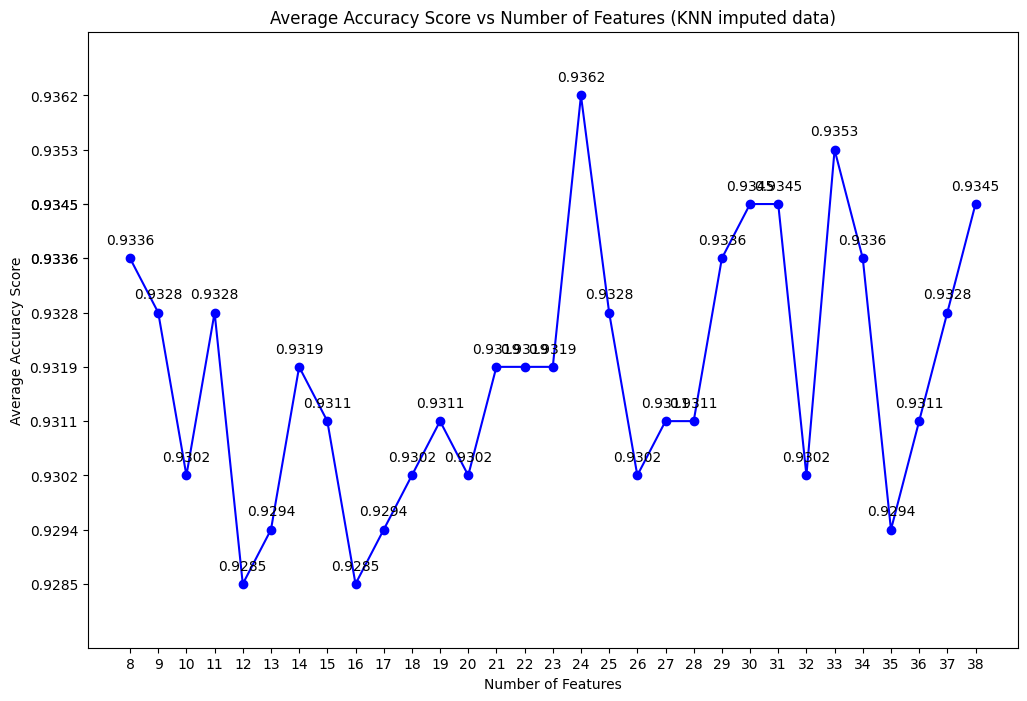

In [49]:
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(top_30_knn_ranked['number_of_features'], top_30_knn_ranked['average_accuracy_score'], marker='o', linestyle='-', color='b')
plt.title('Average Accuracy Score vs Number of Features (KNN imputed data)')
plt.xlabel('Number of Features')
plt.ylabel('Average Accuracy Score')
plt.xticks(top_30_knn_ranked['number_of_features'])

# Get unique accuracy scores, sorted, and formatted to 4 decimal places
unique_scores = sorted(top_30_knn_ranked['average_accuracy_score'].unique())
yticks = [f"{score:.4f}" for score in unique_scores]
plt.yticks(unique_scores, yticks)
plt.ylim(min(unique_scores) - 0.001, max(unique_scores) + 0.001)

# Annotate the points
for i, txt in enumerate(top_30_knn_ranked['average_accuracy_score']):
    plt.annotate(f"{txt:.4f}", (top_30_knn_ranked['number_of_features'][i], top_30_knn_ranked['average_accuracy_score'][i]), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.show()

In [50]:
# Sort features combinations according to average accuracy scores
top_30_ranked_knn_sorted= top_30_knn_ranked.sort_values(by='average_accuracy_score', ascending=False).reset_index(drop=True)
top_30_ranked_knn_sorted

,number_of_features,average_accuracy_score
0,24,0.936170
1,33,0.935319
2,30,0.934468
3,38,0.934468
4,31,0.934468
5,34,0.933617
6,29,0.933617
7,8,0.933617
8,37,0.932766
9,11,0.932766


#### Visualise combinations of top 30 ranked features (MICE-Imputed data)

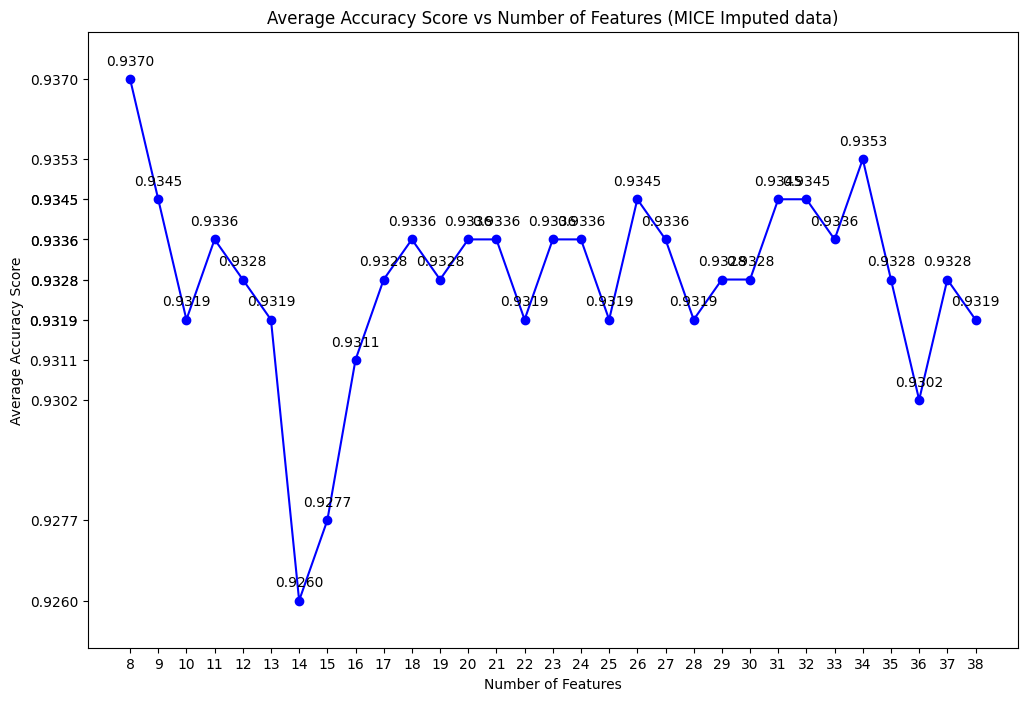

,number_of_features,average_accuracy_score
0,24,0.936170
1,33,0.935319
2,30,0.934468
3,38,0.934468
4,31,0.934468
5,34,0.933617
6,29,0.933617
7,8,0.933617
8,37,0.932766
9,11,0.932766


In [51]:
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(top_30_mice_ranked['number_of_features'], top_30_mice_ranked['average_accuracy_score'], marker='o', linestyle='-', color='b')
plt.title('Average Accuracy Score vs Number of Features (MICE Imputed data)')
plt.xlabel('Number of Features')
plt.ylabel('Average Accuracy Score')
plt.xticks(top_30_mice_ranked['number_of_features'])

# Get unique accuracy scores, sorted, and formatted to 4 decimal places
unique_scores = sorted(top_30_mice_ranked['average_accuracy_score'].unique())
yticks = [f"{score:.4f}" for score in unique_scores]
plt.yticks(unique_scores, yticks)
plt.ylim(min(unique_scores) - 0.001, max(unique_scores) + 0.001)

# Annotate the points
for i, txt in enumerate(top_30_mice_ranked['average_accuracy_score']):
    plt.annotate(f"{txt:.4f}", (top_30_mice_ranked['number_of_features'][i], top_30_mice_ranked['average_accuracy_score'][i]), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.show()

# Sort features combinations according to average accuracy scores
top_30_ranked_mice_sorted= top_30_knn_ranked.sort_values(by='average_accuracy_score', ascending=False).reset_index(drop=True)
top_30_ranked_mice_sorted

### Filter the both KNN and MICE-imputed dataframes based on boruta selected features

In [52]:
# Find the list of selected features and filter out data set with selected features (KNN_imputed)
X_train_br_knn, boruta_feat_knn = boruta_accepted_only(X_train_filtered_knn_df, y_train)

# print shape new data set
print(X_train_br_knn.shape)
print("Number of selected features(knn): ", len(boruta_feat_knn))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	451
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	12
Rejected: 	452
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	12
Rejected: 	452
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	12
Rejected: 	452
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	12
Rejected: 	452
Iteration: 	16 / 100
Confirmed: 	2
Tentat

In [53]:
# Find the list of selected features and filter out data set with selected features (MICE-Imputed)
X_train_br_mice, boruta_feat_mice = boruta_accepted_only(X_train_filtered_mice_df, y_train)

# print shape new data set
print(X_train_br_mice.shape)
print("Number of selected features(knn): ", len(boruta_feat_mice))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	451
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	451
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	451
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	451
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	451
Iteration: 	16 / 100
Confirmed: 	2
Tentat

### 3.8.2 Select Features with Principal Component analysis


[[-3.60297940e+00  1.25295287e+00 -2.66217237e+00 ... -1.17685092e-16
   1.85893370e-16  4.23538650e-16]
 [-3.12423639e+00  6.65629342e-02 -8.22957256e-01 ... -5.42591448e-16
  -1.13575689e-16  9.58072889e-17]
 [-5.58599683e-01  4.92076106e+00 -3.94428753e-01 ...  4.32102783e-16
   2.19956742e-16 -6.14763428e-17]
 ...
 [ 3.03456179e-02  2.15402267e+00 -2.34134435e+00 ...  6.33397092e-16
  -1.75225216e-16 -1.65407534e-16]
 [-7.21469106e+00  2.81446874e+00  1.47482692e+00 ...  1.92907300e-16
  -6.06883706e-17  2.74828743e-16]
 [ 3.44204033e+00  2.83329715e+00 -1.73775164e+00 ... -2.32182040e-16
  -1.58901470e-16 -4.80240780e-16]]
(1175, 466)
[3.99248331e-02 3.41923230e-02 3.09418664e-02 2.50637461e-02
 2.07426081e-02 1.89069271e-02 1.80791354e-02 1.65592392e-02
 1.62658491e-02 1.50784077e-02 1.49269817e-02 1.45933073e-02
 1.36598237e-02 1.32301115e-02 1.30121350e-02 1.24687271e-02
 1.20784935e-02 1.20005213e-02 1.15719257e-02 1.09916018e-02
 1.09007761e-02 1.03170282e-02 1.01920502e-02 9

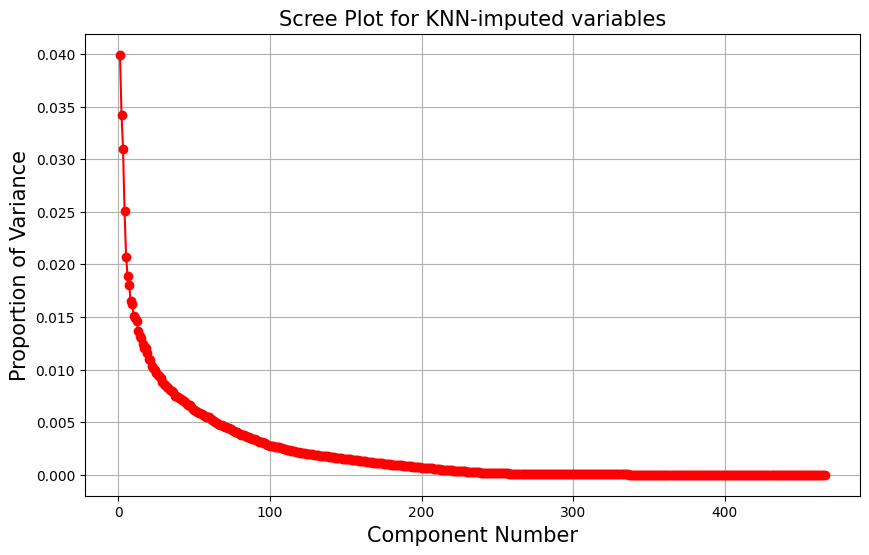

In [54]:
# Determine the number of components to extract for the knn imputed data
pca = PCA()                 # Create PCA object for transforming features

# Transform the knn imputed data
pca_trans_knn = pca.fit_transform(X_train_scaled_knn)     
print(pca_trans_knn)                                                  # Print transformed data
print(pca_trans_knn.shape)                                      # Print dimensions of transformed data

# Extract proportion of explained variance
prop_var = pca.explained_variance_ratio_     
print(prop_var)                                                   # Print proportion of explained variance


PC_number = np.arange(pca.n_components_) + 1 # Enumarate component numbers
print(PC_number)                                                         # Print component numbers

#Scree Plot
plt.figure(figsize=(10, 6))                           # Set figure and size
plt.plot(PC_number,                                   # Plot prop var
         prop_var,
         'ro-')
plt.title('Scree Plot for KNN-imputed variables',       # Plot Annotations
          fontsize = 15)
plt.xlabel('Component Number',
           fontsize = 15)
plt.ylabel('Proportion of Variance',
           fontsize = 15)
plt.grid()                                                       # Add grid lines
plt.show()                                                    # Print graph

[[-3.16053379e+00  2.29197746e+00 -2.72948143e+00 ...  1.12958299e-08
   1.07158811e-08 -1.13181640e-16]
 [-1.70123960e+00  1.37294001e+00 -1.11590865e+00 ...  2.65949578e-06
  -9.60057437e-08  2.24603144e-17]
 [ 6.80962087e-01  4.39815049e+00 -9.92807569e-01 ...  9.38409496e-08
   2.45789794e-09  5.91159948e-16]
 ...
 [-1.07140781e-01  7.57246650e-01 -3.14862291e+00 ... -2.26621156e-08
   6.82003038e-09  4.87866572e-16]
 [-5.81208874e+00  4.99377638e+00  1.19323812e+00 ...  8.65384256e-08
   4.33153855e-09  4.16502972e-16]
 [ 3.80129852e+00  1.09779854e+00 -1.97947411e+00 ... -4.13818537e-08
  -4.90490971e-09 -4.02026012e-16]]
(1175, 466)
[4.16990581e-02 3.69537253e-02 3.10414752e-02 2.59533974e-02
 2.12993910e-02 1.96351379e-02 1.82858745e-02 1.78453616e-02
 1.62455446e-02 1.55579675e-02 1.48591918e-02 1.45555106e-02
 1.40434403e-02 1.34489354e-02 1.30159303e-02 1.28556671e-02
 1.22697857e-02 1.20334319e-02 1.17332412e-02 1.12452066e-02
 1.10775184e-02 1.10238842e-02 1.03195830e-02 9

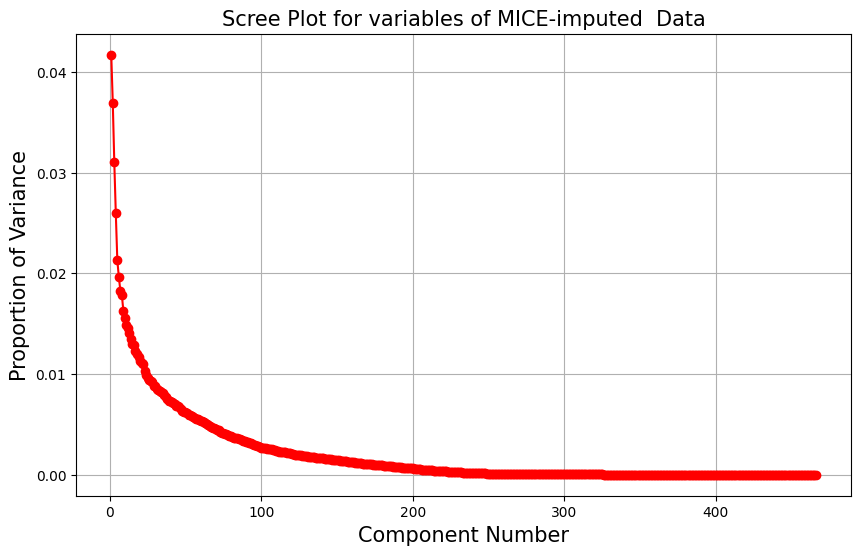

In [55]:
# Determine the number of components to extract for the MICE-imputed data
pca = PCA()                 # Create PCA object for transforming features

# Transform the knn imputed data
pca_trans_mice = pca.fit_transform(X_train_scaled_mice)     
print(pca_trans_mice)                                                  # Print transformed data
print(pca_trans_mice.shape)                                      # Print dimensions of transformed data

# Extract proportion of explained variance
prop_var = pca.explained_variance_ratio_     
print(prop_var)                                                   # Print proportion of explained variance


PC_number = np.arange(pca.n_components_) + 1 # Enumarate component numbers
print(PC_number)                                                         # Print component numbers

#Scree Plot
plt.figure(figsize=(10, 6))                           # Set figure and size
plt.plot(PC_number,                                   # Plot prop var
         prop_var,
         'ro-')
plt.title('Scree Plot for variables of MICE-imputed  Data',       # Plot Annotations
          fontsize = 15)
plt.xlabel('Component Number',
           fontsize = 15)
plt.ylabel('Proportion of Variance',
           fontsize = 15)
plt.grid()                                                       # Add grid lines
plt.show()                                                    # Print graph

Interpretation of PCA applicability Results.
Based on the  the Scree plot and the kaiser creterion, our  data (both KNN and MICE-imputed) is not suitable for PCA analysis.
First, the elbow from the scree plot is highly invible because of the high number of components along the elbow, and therefore determining the number of componets to select is highlz difficult.
secondly, considering the kaiser creterion, the none of components is relevant since their Eingenvalues are less than 1

### 3.9 Resampling of Training dataset

In [56]:
# Create a function for resampling the dataframe

def rose_balancer(X, y, oversample=True):

# Balance data set 
  if oversample:
    ros = RandomOverSampler(random_state=42)
    X_oversampled, y_oversampled = ros.fit_resample(X, y)

  return X_oversampled, y_oversampled

#### Create a Function for  combined under-and-oversampling of data

In [57]:
# Create function to resample data based on combined resampling technique
def combined_balancer(X, y, random_state=42):
    
    # Define the resampling strategy
    majority_class = max(Counter(y), key=Counter(y).get)
    minority_class = min(Counter(y), key=Counter(y).get)
    majority_count = Counter(y)[majority_class]
    minority_count = Counter(y)[minority_class]
    target_minority_count = int(0.75 * majority_count)  # majority class is randomly  undersampled by 25% of majority class
    target_majority_count = int(0.75 * majority_count)  #  minority class is randomly  oversampled by 75% of majority class

    # Oversample the minority class to 75% of the majority class size
    ros = RandomOverSampler(sampling_strategy={minority_class: target_minority_count}, random_state=42)
    # Undersample the majority class to 75% of its original size
    rus = RandomUnderSampler(sampling_strategy={majority_class: target_majority_count}, random_state=42)

    # Create a pipeline
    steps = [('o', ros), ('u', rus)]
    pipeline = Pipeline(steps=steps)

    # Apply the resampling strategy to the data
    X_balanced, y_balanced = pipeline.fit_resample(X, y)

    return X_balanced, y_balanced

#### 3.9.1 Oversample boruta-selected, knn-imputed and MICE_imputed datasets with ROSE


In [58]:
# oversample knn imputed dataset using 'balance_dataset' function
X_train_knn_br_rose, y_train_knn_br_rose = rose_balancer(X_train_br_knn, y_train)

# oversample mice imputed dataset using 'balance_dataset' function
 
X_train_mice_br_rose, y_train_mice_br_rose = rose_balancer(X_train_br_mice, y_train)

# Check the number of records before and after over sampling
print("RECORDS BEFORE RESAMPLING")
print("The Total number of records of negative classification: ", len(X_train))
print("The Total number of records of  classification variable: ", len(y_train))
print("The number of Positive classifications: ", len(y_train[y_train == 1]))
print("The number of negative classifications: ", len(y_train[y_train == -1]))

print("RECORDS AFTER RESAMPLING")
print("The Total number of records X_train DF: ", len(X_train_knn_br_rose))
print("The Total number of records of y_train DF: ", len(y_train_knn_br_rose))
print("The number of Positive classifications: ", len(y_train_knn_br_rose[y_train_knn_br_rose == 1]))
print("The number of negative classifications: ", len(y_train_knn_br_rose[y_train_knn_br_rose == -1]))

RECORDS BEFORE RESAMPLING
The Total number of records of negative classification:  1175
The Total number of records of  classification variable:  1175
The number of Positive classifications:  78
The number of negative classifications:  1097
RECORDS AFTER RESAMPLING
The Total number of records X_train DF:  2194
The Total number of records of y_train DF:  2194
The number of Positive classifications:  1097
The number of negative classifications:  1097


#### 3.9.2  Combined resampling of boruta-selected, knn-imputed and MICE_imputed datasets with ROSE


In [59]:
# resample knn imputed dataset using 'balance_dataset' function
X_train_knn_br_comb, y_train_knn_br_comb = combined_balancer(X_train_br_knn, y_train)

# Resample mice imputed dataset using 'balance_dataset' function
 
X_train_mice_br_comb, y_train_mice_br_comb = combined_balancer(X_train_br_mice, y_train)

# Check the number of records before and after over sampling
print("RECORDS BEFORE RESAMPLING")
print("The Total number of records of negative classification: ", len(X_train))
print("The Total number of records of  classification variable: ", len(y_train))
print("The number of Positive classifications: ", len(y_train[y_train == 1]))
print("The number of negative classifications: ", len(y_train[y_train == -1]))

print("RECORDS AFTER RESAMPLING")
print("The Total number of records X_train DF: ", len(X_train_knn_br_comb))
print("The Total number of records of y_train DF: ", len(y_train_knn_br_comb))
print("The number of Positive classifications: ", len(y_train_knn_br_comb[y_train_knn_br_comb == 1]))
print("The number of negative classifications: ", len(y_train_knn_br_comb[y_train_knn_br_comb == -1]))

RECORDS BEFORE RESAMPLING
The Total number of records of negative classification:  1175
The Total number of records of  classification variable:  1175
The number of Positive classifications:  78
The number of negative classifications:  1097
RECORDS AFTER RESAMPLING
The Total number of records X_train DF:  1644
The Total number of records of y_train DF:  1644
The number of Positive classifications:  822
The number of negative classifications:  822


#### 3.9.3 SMOTE Oversampling


In [60]:
#Define Smote oversampler model
smote = SMOTE(random_state=42)
# oversample knn imputed dataset using SMOTE
X_train_knn_br_smote, y_train_knn_br_smote = smote.fit_resample(X_train_br_knn, y_train)

# oversample mice imputed dataset using SMOTE
 
X_train_mice_br_smote, y_train_mice_br_smote = smote.fit_resample(X_train_br_mice, y_train)

#### Oversample boruta-selected, knn-imputed and MICE_imputed datasets with SMOTE

In [61]:

# Check the number of records before and after over sampling
print("RECORDS BEFORE RESAMPLING")
print("The Total number of records of X_train DF: ", len(X_train))
print("The Total number of records of  y_train DF: ", len(y_train))
print("The number of Positive classifications: ", len(y_train[y_train == 1]))
print("The number of negative classifications: ", len(y_train[y_train == -1]))

print("RECORDS AFTER RESAMPLING")
print("The Total number of records of X_train DF: ", len(X_train_knn_br_smote))
print("The Total number of records of y_trained DF: ", len(y_train_knn_br_smote))
print("The number of Positive classifications: ", len(y_train_knn_br_smote[y_train_knn_br_smote == 1]))
print("The number of negative classifications: ", len(y_train_knn_br_smote[y_train_knn_br_smote == -1]))


RECORDS BEFORE RESAMPLING
The Total number of records of X_train DF:  1175
The Total number of records of  y_train DF:  1175
The number of Positive classifications:  78
The number of negative classifications:  1097
RECORDS AFTER RESAMPLING
The Total number of records of X_train DF:  2194
The Total number of records of y_trained DF:  2194
The number of Positive classifications:  1097
The number of negative classifications:  1097


#### 3.9.4 ADASYN (adaptive synthetic sampling) of KNN_imputed datasets with ROSE

In [62]:
#Define ADASYN oversampler model
adasyn = ADASYN(random_state=42)

# oversample knn imputed dataset using ADASYN
X_train_knn_br_adas, y_train_knn_br_adas = adasyn.fit_resample(X_train_br_knn, y_train)

# oversample mice imputed dataset using ADASYN
 
X_train_mice_br_adas, y_train_mice_br_adas = adasyn.fit_resample(X_train_br_mice, y_train)

In [63]:
# Check the number of records before and after over sampling
print("RECORDS BEFORE RESAMPLING")
print("The Total number of records of X_train DF: ", len(X_train))
print("The Total number of records of  y_train DF: ", len(y_train))
print("The number of Positive classifications: ", len(y_train[y_train == 1]))
print("The number of negative classifications: ", len(y_train[y_train == -1]))

print("RECORDS AFTER RESAMPLING")
print("The Total number of records of X_train DF: ", len(X_train_knn_br_adas))
print("The Total number of records of y_trained DF: ", len(y_train_knn_br_adas))
print("The number of Positive classifications: ", len(y_train_knn_br_adas[y_train_knn_br_adas == 1]))
print("The number of negative classifications: ", len(y_train_knn_br_adas[y_train_knn_br_adas == -1]))

RECORDS BEFORE RESAMPLING
The Total number of records of X_train DF:  1175
The Total number of records of  y_train DF:  1175
The number of Positive classifications:  78
The number of negative classifications:  1097
RECORDS AFTER RESAMPLING
The Total number of records of X_train DF:  2174
The Total number of records of y_trained DF:  2174
The number of Positive classifications:  1077
The number of negative classifications:  1097


### 4.0 Clean and tranform Test data

#### Clean and Select features with BORUTA selector

In [64]:
# Drop low variance columns
X_test_low_var =X_test_df.drop(columns=columns_dropped1)
print(X_test_low_var.shape[1])

# Drop NAs columns
X_test_nadroped = X_test_low_var.drop(columns=columns_dropped2)
print(X_test_nadroped.shape[1])

# Replace outliers with 3s bounds
X_test_filled = fill_outliers(X_test_nadroped)

print(X_test_filled.shape)

# Impute NAs knn
X_test_imputed_knn = fill_nas_knn(X_test_filled)
print(X_test_imputed_knn[1:4,:])

# Impute NAs mice
X_test_imputed_mice = impute_na(X_test_filled)
print(X_test_imputed_mice[1:4,:])

# Scale the test dataset (KNN data)
X_test_scaled_knn= scale_dataset(X_test_imputed_knn)
print(X_test_scaled_knn[1:2,1:10])

# Scale the test dataset (MICE data)
X_test_scaled_mice= scale_dataset(X_test_imputed_mice)
print(X_test_scaled_mice[1:2,1:10])

# Get the indices of selected features in the Test DataFrame (KNN)

selected_indices_knn = [X_train_df2.columns.get_loc(col) for col in boruta_feat_knn]

# Get the indices of selected features in the Test DataFrame(MICE)

selected_indices_mice = [X_train_df2.columns.get_loc(col) for col in boruta_feat_mice]


# Subset Test dataset with boruta (knn data)
X_test_knn_br = X_test_scaled_knn[:, selected_indices_knn]

print(X_test_knn_br.shape)

# Subset Test dataset with boruta (MICE data)
X_test_mice_br = X_test_scaled_mice[:, selected_indices_mice]

print(X_test_mice_br.shape)


475
466
(392, 466)
[[3.0704300e+03 2.4463800e+03 2.2555222e+03 ... 8.7000000e-03
  3.2000000e-03 4.1061100e+01]
 [3.0860500e+03 2.4173400e+03 2.2165000e+03 ... 1.9000000e-02
  5.3000000e-03 1.0138760e+02]
 [3.0971400e+03 2.4630600e+03 2.1553111e+03 ... 1.0900000e-02
  3.6000000e-03 5.1547200e+01]]


c:\Users\MajeedAbdul-Razak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[[3.0704300e+03 2.4463800e+03 2.2555222e+03 ... 8.7000000e-03
  3.2000000e-03 4.1061100e+01]
 [3.0860500e+03 2.4173400e+03 2.2165000e+03 ... 1.9000000e-02
  5.3000000e-03 1.0138760e+02]
 [3.0971400e+03 2.4630600e+03 2.1553111e+03 ... 1.0900000e-02
  3.6000000e-03 5.1547200e+01]]
[[-0.59137531  1.87771045  0.89145791 -0.07782439  0.11048401 -0.6097149
   2.09007694 -1.19524065  0.80703219]]
[[-0.59120175  1.8826945   0.89024925 -0.0787167   0.11126466 -0.60617506
   2.09007694 -1.19524065  0.80703219]]
(392, 8)
(392, 10)


## 5.0 Model Building, Evalutation and Selection

#### 5.1 Models building and crossbalidation

In [65]:

# Define KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the models to be used
models = {
    'KNeighbors': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(), 'Logistic regression' : LogisticRegression(),
    'GaussianNB' : GaussianNB(), 'Gradient Booster' : GradientBoostingClassifier()
      
}



### Cross-validation of selected models

### 5.1.1 Cross-validation with KNN-imputed, Boruta-selected and ROSE-oversampled dataset

In [66]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_knn_br_rose, y_train_knn_br_rose, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model


# Create a cross table of CV results
print("Cross-validation results (mean accuracy):")
cv1=pd.DataFrame(model_results, index=['KNN/Boruta/ROSE'])
cv1

Cross-validation results (mean accuracy):


,KNeighbors,Random Forest,Decision Tree,SVM,Logistic regression,GaussianNB,Gradient Booster
KNN/Boruta/ROSE,0.938927,0.994527,0.970828,0.766631,0.684591,0.69098,0.930262


### 5.1.2. Cross-validation with KNN-imputed, Boruta-selected and SMOTE-oversampled dataset

In [67]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_knn_br_smote, y_train_knn_br_smote, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model


# Create a cross table of CV results
print("Cross-validation results (mean accuracy):")
cv2=pd.DataFrame(model_results, index=['KNN/Boruta/SMOTE'])
cv2

Cross-validation results (mean accuracy):


,KNeighbors,Random Forest,Decision Tree,SVM,Logistic regression,GaussianNB,Gradient Booster
KNN/Boruta/SMOTE,0.877854,0.943022,0.854589,0.793547,0.696005,0.680515,0.824516


### 5.1.3. Cross-validation with KNN-imputed, Boruta-selected and Combined-resampled dataset

In [68]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_knn_br_comb, y_train_knn_br_comb, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model

# Create a cross table of CV results
print("Cross-validation results (mean accuracy):")
cv3=pd.DataFrame(model_results, index=['KNN/Boruta/Combined Resampling'])
cv3

Cross-validation results (mean accuracy):


,KNeighbors,Random Forest,Decision Tree,SVM,Logistic regression,GaussianNB,Gradient Booster
KNN/Boruta/Combined Resampling,0.928245,0.989065,0.958019,0.751238,0.68007,0.689812,0.921548


### 5.1.4. Cross-validation with MICE-imputed, Boruta-selected and ROSE-oversampled dataset

In [69]:
#With MICE

# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_mice_br_rose, y_train_mice_br_rose, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model

# Create a cross table of CV results
print("Cross-validation results (mean accuracy):")
cv4=pd.DataFrame(model_results, index=['MICE/Boruta/ROSE'])
cv4

Cross-validation results (mean accuracy):


,KNeighbors,Random Forest,Decision Tree,SVM,Logistic regression,GaussianNB,Gradient Booster
MICE/Boruta/ROSE,0.948493,0.993159,0.963985,0.856895,0.706486,0.706036,0.950776


### 5.1.5. Cross-validation with MICE-imputed, Boruta-selected and SMOTE-oversampled dataset

In [70]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_mice_br_smote, y_train_mice_br_smote, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model

# Create a cross table of CV results
print("Cross-validation results (mean accuracy):")
cv5=pd.DataFrame(model_results, index=['MICE/Boruta/SMOTE'])
cv5

Cross-validation results (mean accuracy):


,KNeighbors,Random Forest,Decision Tree,SVM,Logistic regression,GaussianNB,Gradient Booster
MICE/Boruta/SMOTE,0.89243,0.95032,0.881507,0.855058,0.720189,0.671864,0.865556


### 5.1.6. Cross-validation with MICE-imputed, Boruta-selected and Combined-resampled dataset

In [71]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_mice_br_comb, y_train_mice_br_comb, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model

# Create a cross table of CV results
print("Cross-validation results (mean accuracy):")
cv6=pd.DataFrame(model_results, index=['MICE/Boruta/Combined Resampling'])
cv6

Cross-validation results (mean accuracy):


,KNeighbors,Random Forest,Decision Tree,SVM,Logistic regression,GaussianNB,Gradient Booster
MICE/Boruta/Combined Resampling,0.945255,0.99088,0.959228,0.850407,0.708071,0.695898,0.942831


### 5.1.7. Cross-validation with Mice-imputed, Boruta-selected and ADASYN-oversampled dataset

In [72]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_mice_br_adas, y_train_mice_br_adas, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model

# Create a cross table of CV results
print("Cross-validation results (mean accuracy):")
cv7=pd.DataFrame(model_results, index=['MICE/Boruta/ADASYN'])
cv7

Cross-validation results (mean accuracy):


,KNeighbors,Random Forest,Decision Tree,SVM,Logistic regression,GaussianNB,Gradient Booster
MICE/Boruta/ADASYN,0.896099,0.942615,0.850897,0.860385,0.70628,0.658826,0.860809


### 5.1.8. Cross-validation with KNN-imputed, Boruta-selected and ADASYN-oversampled dataset

In [73]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_knn_br_adas, y_train_knn_br_adas, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model

# Create a cross table of CV results
print("Cross-validation results (mean accuracy):")
cv8=pd.DataFrame(model_results, index=['KNN/Boruta/ADASYN'])
cv8

Cross-validation results (mean accuracy):


,KNeighbors,Random Forest,Decision Tree,SVM,Logistic regression,GaussianNB,Gradient Booster
KNN/Boruta/ADASYN,0.878108,0.936518,0.848174,0.785606,0.672936,0.659136,0.820126


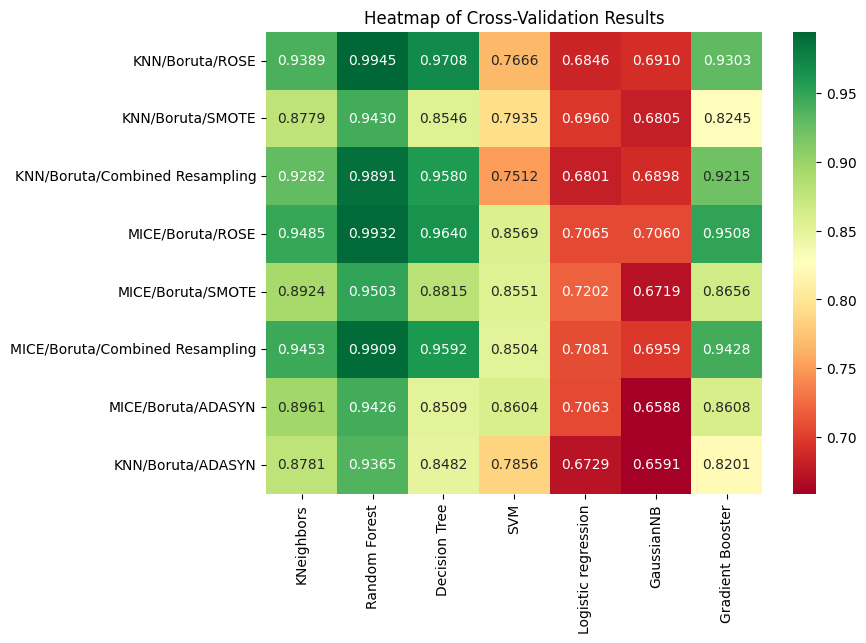

In [74]:
# Create a Heatmap of Crossvalidation results
cv_all= pd.concat([cv1, cv2, cv3, cv4, cv5, cv6,cv7, cv8]) # merge CV scores tables
cv_all
# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cv_all, annot=True, fmt=".4f", cmap="RdYlGn", cbar=True)
plt.title('Heatmap of Cross-Validation Results')
plt.show()

#### 6.1.3. Build the Final model


Test set accuracy: 0.7577
Classification report:
              precision    recall  f1-score   support

          -1       0.96      0.77      0.86       366
           1       0.14      0.54      0.23        26

    accuracy                           0.76       392
   macro avg       0.55      0.66      0.54       392
weighted avg       0.91      0.76      0.81       392

Confusion Matrix:
[[283  83]
 [ 12  14]]


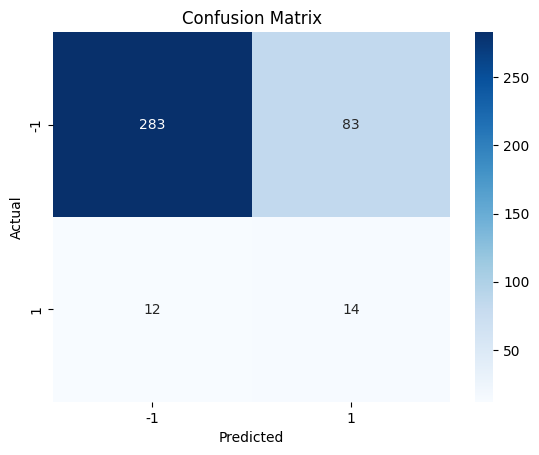

In [115]:
# Train the Chosen final model
final_model_rf = RandomForestClassifier(random_state=42, n_estimators=200, min_samples_split=200,
                                        min_samples_leaf=50, max_depth = 10 )
final_model_rf.fit(X_train_mice_br_rose, y_train_mice_br_rose)

# Test the model on the test set
y_pred = final_model_rf.predict(X_test_mice_br)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matri
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()





Test set accuracy: 0.6811
Classification report:
              precision    recall  f1-score   support

          -1       0.97      0.68      0.80       366
           1       0.14      0.73      0.23        26

    accuracy                           0.68       392
   macro avg       0.56      0.70      0.52       392
weighted avg       0.92      0.68      0.76       392

Confusion Matrix:
[[248 118]
 [  7  19]]


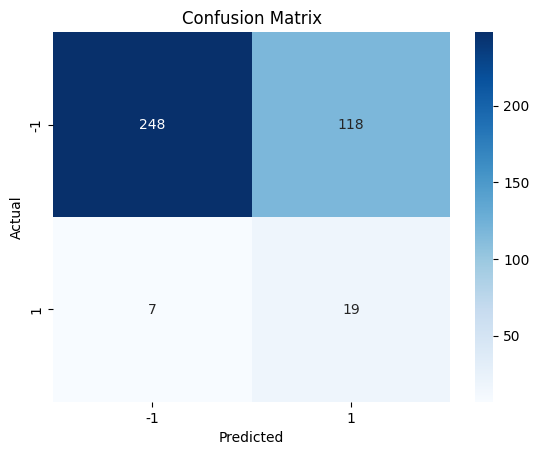

In [113]:
# Train the Chosen final model
para= {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


knc = KNeighborsClassifier(**para)
knc.fit(X_train_knn_br_comb, y_train_knn_br_comb)

# Test the model on the test set
y_pred = knc.predict(X_test_knn_br)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matri
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.741


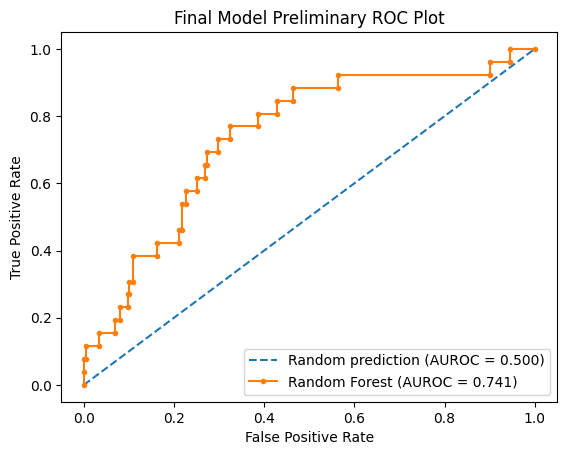

In [76]:

# Calculate ROC curve
r_probs = [0 for _ in range(len(y_test))]
rf_probs = final_model_rf.predict_proba(X_test_mice_br)

# predictict probabilities
rf_probs = rf_probs[:, 1]
r_auc = roc_auc_score(y_test, r_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))

# Calculate the Area Under ROC(AUROC)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# Plot the ROC Curve
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)

# Title
plt.title('Final Model Preliminary ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() 
# Show plot
plt.show()



Test set accuracy: 0.7730
Classification report:
              precision    recall  f1-score   support

          -1       0.97      0.78      0.86       366
           1       0.18      0.69      0.29        26

    accuracy                           0.77       392
   macro avg       0.58      0.74      0.58       392
weighted avg       0.92      0.77      0.83       392

Confusion Matrix:
[[285  81]
 [  8  18]]


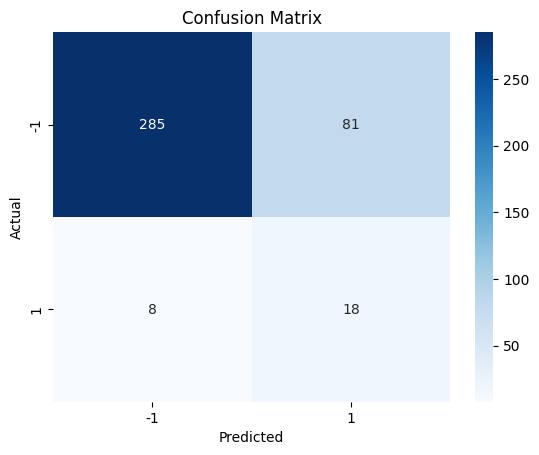

In [ ]:
params= {'max_depth': 10,
  'max_features': 1,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 70}


# Train the Chosen final model
final_model_rf = RandomForestClassifier(random_state=42, n_estimators=12, 
                                        min_samples_leaf=100, max_features=3)
final_model_rf.fit(X_train_mice_br_rose, y_train_mice_br_rose)

# Test the model on the test set
y_pred = final_model_rf.predict(X_test_mice_br)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matri
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [100]:

# Define custom scorer function to extract confusion matrix metrics
def confusion_matrix_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn, fp, fn,  tp



# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(3, 100)),  # n_neighbors from 3 to 99
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}



# Initialize the Random Forest classifier
knc = KNeighborsClassifier()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=knc, param_grid=param_grid, scoring='accuracy', refit='accuracy', return_train_score=True, cv=2,verbose=1)
grid_search.fit(X_train_knn_br_comb, y_train_mice_br_comb)

# Get all parameter configurations
param_configs = grid_search.cv_results_['params']

# Prepare a list to store test set F1 scores for each configuration
conf_mat = []

for params in param_configs:
    # Train the model with the given parameters
    knc.set_params(**params)
    knc.fit(X_train_knn_br_comb, y_train_knn_br_comb)
   
    # Predict on the test set
    y_pred = knc.predict(X_test_knn_br)
   
    # Calculate  scores for the test set
    tn, fn, fp,  tp = confusion_matrix_metrics(y_test, y_pred)
    # Store the results in a dictionary
    conf_mat.append({
        'params': params,
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,
    })
par_df= pd.DataFrame(conf_mat)
# Print gridsearch dataframe confusion for matrix values
print(par_df.head())

# Create csv file for gridsearch dataframe for confusion matrix values
par_df.to_csv('results_df.csv', index=False)


Fitting 2 folds for each of 7760 candidates, totalling 15520 fits
                                              params  true_positive  \
0  {'algorithm': 'auto', 'leaf_size': 10, 'n_neig...              8   
1  {'algorithm': 'auto', 'leaf_size': 10, 'n_neig...              8   
2  {'algorithm': 'auto', 'leaf_size': 10, 'n_neig...              5   
3  {'algorithm': 'auto', 'leaf_size': 10, 'n_neig...              5   
4  {'algorithm': 'auto', 'leaf_size': 10, 'n_neig...              8   

   true_negative  false_positive  false_negative  
0            318              48              18  
1            319              47              18  
2            324              42              21  
3            324              42              21  
4            318              48              18  


### Create a function for searching for maximum True Positive 

In [138]:

def find_maximum_true_positives(model, Classifier, X_train_var, y_train_var, X_test_var, y_test_var, param_grid):  # Define model and parameter before input
# classifier e.g. 'RandomForestClassifier'
    # Create a list of all parameter combinations
    keys, values = zip(*param_grid.items())
    permutations = [dict(zip(keys, v)) for v in product(*values)]

    # The list of all permutations
    print(f"Total number of permutations: {len(permutations)}")
    permutations

    # Prepare a list to store test set F1 scores for each configuration
    conf_mat = []

    for perm in permutations:
        # Train the model with the given parameters
        model.set_params(**perm)
        model.fit(X_train_var, y_train_var)
    
        # Predict on the test set
        y_pred = model.predict(X_test_var)
    
        # Calculate  scores for the test set
        tn, fn, fp,  tp = confusion_matrix_metrics(y_test_var, y_pred)
        # Store the results in a dictionary
        conf_mat.append({
            'params': perm,
            'true_positive': tp,
            'true_negative': tn,
            'false_positive': fp,
            'false_negative': fn,
        })
    para_df= pd.DataFrame(conf_mat)
    para_df.to_csv('cm_results.csv', index=False)
    print(para_df.head())

    # Step 1: Find the highest TP value
    max_tp = para_df['true_positive'].max()

    # Step 2: Filter the DataFrame to include only rows with the highest TP
    df_highest_tp = para_df[para_df['true_positive'] == max_tp]

    # Step 3: Among those rows, find the one with the lowest FP
    row_with_lowest_fp = df_highest_tp.loc[df_highest_tp['false_positive'].idxmin()]

    # Step 4: Store the param value of the selected row to best_param
    best_param = row_with_lowest_fp['params']
    print("\nRow with the highest TP and lowest FP:")
    print(row_with_lowest_fp)

    print(f"\nBest param: {best_param}")
    
    ######################################################################
    
    
    
    ##############################################
    
    
    # Build Model with best parameters of KNeighborsClassifier model

    # Train the Chosen final model
    final_model = Classifier(**best_param)

    final_model.fit(X_train_var, y_train_var)

    # Test the model on the test set
    y_pred = final_model.predict(X_test_var)
    # Test the model on the test set
    y_pred = final_model.predict(X_test_var)

    test_accuracy = accuracy_score(y_test_var, y_pred)

    print(f"\nTest set accuracy: {test_accuracy:.4f}")
    print("Classification report:")
    print(classification_report(y_test_var, y_pred))

    # Create the confusion matrix
    conf_matrix = confusion_matrix(y_test_var, y_pred)

    # Display the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Visualize the confusion matri
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    return(row_with_lowest_fp)



    # DRAW A LINE GRAPH OF BEST 30 TRUE POSITIVES 
    
    # Step 1: Sort by 'true_positive' in descending order and then by 'false_negative' in ascending order
    para_df_sorted = para_df.sort_values(by=['true_positive', 'false_negative'], ascending=[False, True])

    # Step 2: Drop the index and select the first 30 rows
    para_df_sorted = para_df_sorted.reset_index(drop=True).head(30)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot true_positive on the left y-axis
    ax1.plot(para_df_sorted['params'], para_df_sorted['true_positive'], 'g-', label='True Positive')
    ax1.set_xlabel('Params')
    ax1.set_ylabel('True Positive', color='g')
    ax1.tick_params('y', colors='g')

    # Create a second y-axis for false_negative
    ax2 = ax1.twinx()
    ax2.plot(para_df_sorted['params'], para_df_sorted['false_negative'], 'r-', label='False Negative')
    ax2.set_ylabel('False Negative', color='r')
    ax2.tick_params('y', colors='r')

    # Adding title and showing the plot
    plt.title('True Positive and False Negative against Params')
    fig.tight_layout()
    plt.show()

# KNeighbor Classifier

Total number of permutations: 7760
                                              params  true_positive  \
0  {'n_neighbors': 3, 'weights': 'uniform', 'algo...              8   
1  {'n_neighbors': 3, 'weights': 'uniform', 'algo...              6   
2  {'n_neighbors': 3, 'weights': 'uniform', 'algo...              8   
3  {'n_neighbors': 3, 'weights': 'uniform', 'algo...              6   
4  {'n_neighbors': 3, 'weights': 'uniform', 'algo...              8   

   true_negative  false_positive  false_negative  
0            331              18              35  
1            334              20              32  
2            331              18              35  
3            334              20              32  
4            331              18              35  

Row with the highest TP and lowest FP:
params            {'n_neighbors': 43, 'weights': 'distance', 'al...
true_positive                                                    18
true_negative                                           

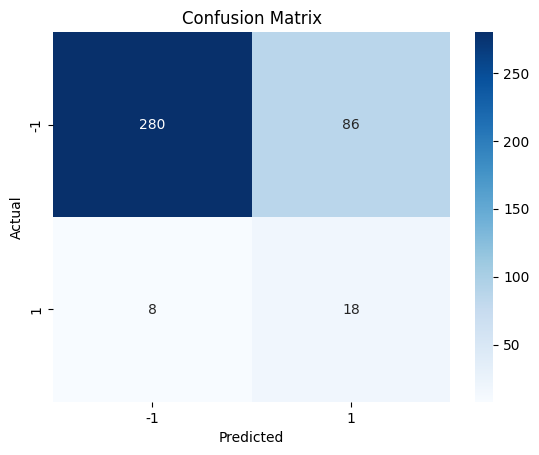

Best KNClassifier True Positives:  params            {'n_neighbors': 43, 'weights': 'distance', 'al...
true_positive                                                    18
true_negative                                                   280
false_positive                                                    8
false_negative                                                   86
Name: 3240, dtype: object


In [139]:
# Define the parameter grid
knc_param = {
    'n_neighbors': list(range(3, 100)),  # n_neighbors from 3 to 99
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

knc = KNeighborsClassifier()


knn_best_tp= find_maximum_true_positives(knc, KNeighborsClassifier, X_train_mice_br_rose, y_train_mice_br_rose, X_test_mice_br, y_test, knc_param)

print("Best KNClassifier True Positives: ", knn_best_tp)

# RANDOM FOREST


Total number of permutations: 24960


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

                                              params  true_positive  \
0  {'random_state': 42, 'verbose': 1, 'n_estimato...              6   
1  {'random_state': 42, 'verbose': 1, 'n_estimato...             11   
2  {'random_state': 42, 'verbose': 1, 'n_estimato...              7   
3  {'random_state': 42, 'verbose': 1, 'n_estimato...              5   
4  {'random_state': 42, 'verbose': 1, 'n_estimato...             10   

   true_negative  false_positive  false_negative  
0            308              20              58  
1            301              15              65  
2            300              19              66  
3            298              21              68  
4            286              16              80  

Row with the highest TP and lowest FP:
params            {'random_state': 42, 'verbose': 1, 'n_estimato...
true_positive                                                    21
true_negative                                                   221
false_positive         

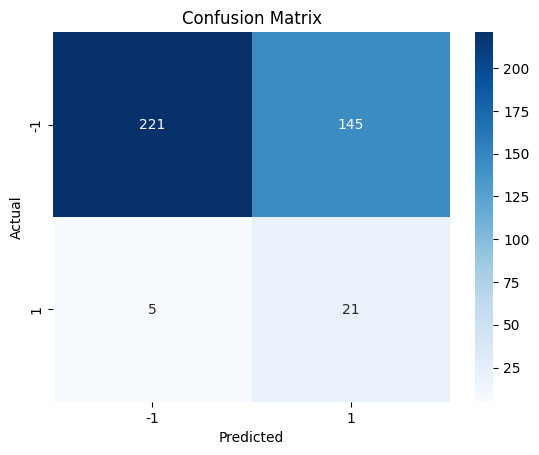

Best Random Forest True Positives:  params            {'n_neighbors': 43, 'weights': 'distance', 'al...
true_positive                                                    18
true_negative                                                   280
false_positive                                                    8
false_negative                                                   86
Name: 3240, dtype: object


In [144]:
#RANDOM FOREST

# Define the parameter grid
rf_param ={
    'random_state': [42],
    'verbose': [1],
    'n_estimators': [1,3,5,7,9,10,11,12, 20, 50,100, 200],
    'max_features': [2,3,4,5,6,7,8,9,10,20,40,60,70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 5, 20, 30],
    'min_samples_leaf': [7, 8,9,10, 20, 50, 100, 200]
  
}

rf= RandomForestClassifier()



rf_best_tp= find_maximum_true_positives(rf, RandomForestClassifier, X_train_knn_br_rose, y_train_knn_br_rose, X_test_knn_br, y_test, rf_param)

print("Best Random Forest True Positives: ", knn_best_tp)



   


## Build Cost-effective Random Forest Model


Test set accuracy: 0.7883
Classification report:
              precision    recall  f1-score   support

          -1       0.98      0.79      0.87       366
           1       0.20      0.73      0.31        26

    accuracy                           0.79       392
   macro avg       0.59      0.76      0.59       392
weighted avg       0.92      0.79      0.84       392

Confusion Matrix:
[[290  76]
 [  7  19]]


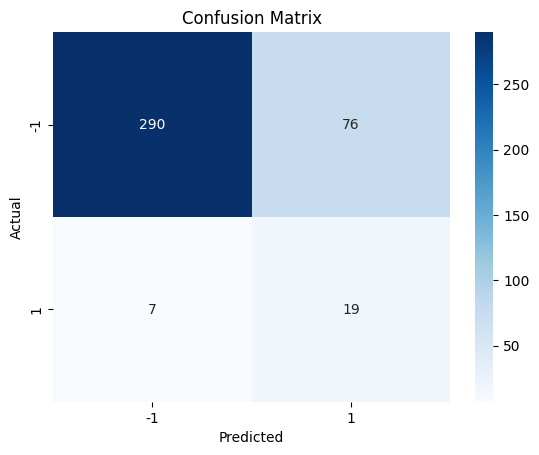

In [145]:
#  Best parameters of Random Forest model
best_param= {'random_state': 42, 'verbose': 1, 'n_estimators': 1, 'max_features': 3, 'max_depth': 10, 'min_samples_split': 30, 'min_samples_leaf': 7}

# Train the Chosen final model
final_model_rf = RandomForestClassifier(**best_param)

final_model_rf.fit(X_train_knn_br_rose, y_train_knn_br_rose)

# Test the model on the test set
y_pred = final_model_rf.predict(X_test_knn_br)
# Test the model on the test set
y_pred = final_model_rf.predict(X_test_knn_br)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matri
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#RANDOM FOREST

# Define the parameter grid
rf_param ={
    'random_state': [42],
    'verbose': [1],
    'n_estimators': [1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,20, 200, 300],
    'max_features': [2,3,4,5,6,7,8,9,10,20,40,60,70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 5, 20, 30],
    'min_samples_leaf': list(range(10, 121, 10)),
  
}

rf= RandomForestClassifier()



rf_best_tp= find_maximum_true_positives(rf, RandomForestClassifier, X_train_knn_br_rose, y_train_knn_br_rose, X_test_knn_br, y_test, rf_param)

print("Best Random Forest True Positives: ", knn_best_tp)




# Decision Trees Model

Total number of permutations: 10240
                                              params  true_positive  \
0  {'criterion': 'gini', 'splitter': 'best', 'ran...              7   
1  {'criterion': 'gini', 'splitter': 'best', 'ran...              7   
2  {'criterion': 'gini', 'splitter': 'best', 'ran...              9   
3  {'criterion': 'gini', 'splitter': 'best', 'ran...              9   
4  {'criterion': 'gini', 'splitter': 'best', 'ran...              9   

   true_negative  false_positive  false_negative  
0            327              19              39  
1            323              19              43  
2            322              17              44  
3            321              17              45  
4            291              17              75  

Row with the highest TP and lowest FP:
params            {'criterion': 'gini', 'splitter': 'best', 'ran...
true_positive                                                    24
true_negative                                          

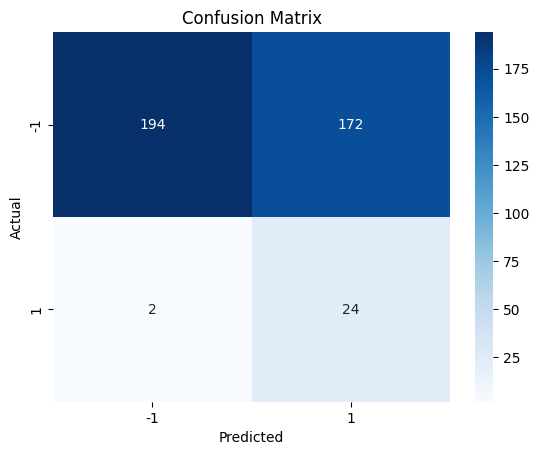

Best Random Forest True Positives:  params            {'criterion': 'gini', 'splitter': 'best', 'ran...
true_positive                                                    24
true_negative                                                   194
false_positive                                                    2
false_negative                                                  172
Name: 327, dtype: object


In [147]:
# Define the parameter grid
dt_param ={
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'random_state': [42],
    'max_features': [None, 'sqrt', 'log2',2,3,4,5,6,7,8,9,10,20,40,60,70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 5, 20, 30],
    'min_samples_leaf': [7, 8,9,10, 20, 50, 100, 200]
  
}

dt = DecisionTreeClassifier()


dt_best_tp= find_maximum_true_positives(dt, DecisionTreeClassifier, X_train_knn_br_rose, y_train_knn_br_rose, X_test_knn_br, y_test, dt_param)

print("Best Random Forest True Positives: ", dt_best_tp)

## Build Cost-effective Random Forest Model


Test set accuracy: 0.7806
Classification report:
              precision    recall  f1-score   support

          -1       0.98      0.78      0.87       366
           1       0.19      0.73      0.31        26

    accuracy                           0.78       392
   macro avg       0.59      0.76      0.59       392
weighted avg       0.92      0.78      0.83       392

Confusion Matrix:
[[287  79]
 [  7  19]]


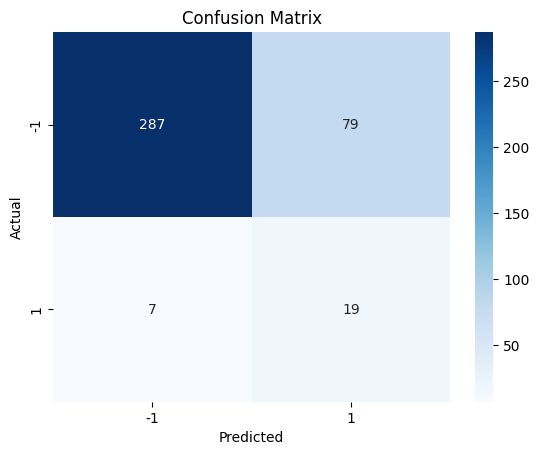

In [148]:
#  Best parameters of Random Forest model
best_param= {'criterion': 'entropy', 'splitter': 'random', 'random_state': 42, 'max_features': 4, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 7}


# Train the Chosen final model
final_model_dt = DecisionTreeClassifier(**best_param)

final_model_dt.fit(X_train_knn_br_rose, y_train_knn_br_rose)

# Test the model on the test set
y_pred = final_model_dt.predict(X_test_knn_br)
# Test the model on the test set
y_pred = final_model_dt.predict(X_test_knn_br)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matri
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()